In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


In [2]:
# Define functions for LeakyReLU, ReLU, and proximal of f corresponding to 
# LeakyReLU

def LeakyReLU(x,a):
    return np.maximum(x,a*x)

def proxalpha(x,alpha,a):
    return np.maximum(x,1/(1-(1-1/a)*alpha)*x)

def ReLU(x):
    return np.maximum(x,0)

In [3]:
# Do projection onto set of matrices satisfying a mu_inf constraint

def mu_inf_proj(T,gamma):
    A = cp.Variable((n,n))
    X = cp.Variable((n,n))
    objective = cp.Minimize(cp.norm(A - T, 'fro'))
    constraints = [(cp.diag(cp.diag(A)) + X) @ np.ones((n,1)) <= gamma*np.ones((n,1)),
                  -X <= A - cp.diag(cp.diag(A)),
                  X >= A - cp.diag(cp.diag(A)),
                  cp.diag(X) == np.zeros(n)]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver='SCS')
    return A.value

In [4]:
# Pick dimensions and generate random matrices

n = 200
m = 50
np.random.seed(42)

T = np.random.randn(n,n)
# print(T)
B = np.random.randn(n,m)
u = np.random.randn(m,1)
b = np.random.randn(n,1)

In [5]:
# Pick hyperparameter gamma for monotonicity parameter
gamma = 0.9

# Project A onto the set of matrices satisfying mu_inf(A) <= gamma
A = mu_inf_proj(T,gamma)

# Check minimal diagonal entry to see if it is positive
minaii = np.min(np.diag(A))
print(minaii)

-4.5026418093004095


In [6]:
# Forward step method

alpha = 1/(1-min(minaii, 0.1*minaii))
print(alpha) 

residual = []
x = np.zeros((n,1))

for i in range(100):
    x = (1 - alpha)*x + alpha*LeakyReLU(A@x + B@u + b,0.1)
    res = np.linalg.norm(x - LeakyReLU(A@x + B@u + b,0.1), float('inf'))
    residual.append(res)

np.save('FwdStepLRGamma09', residual)

0.18173089120753386


In [7]:
# Forward-backward splitting

alpha = 1/(1-minaii)
print(alpha)

residual_FB = []
x = np.zeros((n,1))

for i in range(100):
    x = proxalpha((1 - alpha)*x + alpha*(A@x + B@u + b),alpha, 0.1)
    res = np.linalg.norm(x - LeakyReLU(A@x + B@u + b,0.1), float('inf'))
    residual_FB.append(res)

np.save('FwdBwdLRGamma09', residual_FB)

0.18173089120753386


In [9]:
# Peaceman-Rachford

alpha = 1/(1-minaii)

print(alpha)
In = np.eye(n)

residual_PR = []
x = np.zeros((n,1))
z = np.zeros((n,1))

for i in range(100):
    x = np.linalg.solve(In + alpha*(In - A), z + alpha*(B @ u + b))
    z = z + 2*proxalpha(2*x - z, alpha, 0.1) - 2*x
    res = np.linalg.norm(x - LeakyReLU(A@x + B@u + b,0.1), float('inf'))
    residual_PR.append(res)

np.save('PRLRGamma09', residual_PR)

0.18173089120753386


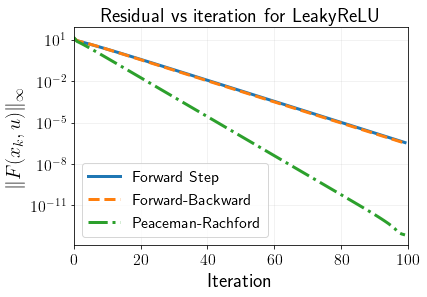

In [12]:
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams.update({'font.size': 16})
plt.grid(alpha=0.2)

fwdstepLR09 = np.load('FwdStepLRGamma09.npy')
fwdbwdLR09 = np.load('FwdBwdLRGamma09.npy')
PRLR09 = np.load('PRLRGamma09.npy')

plt.plot(range(100),fwdstepLR09, label='Forward Step', linewidth = 3)
plt.plot(range(100),fwdbwdLR09, '--', label='Forward-Backward', linewidth = 3)
plt.plot(range(100),PRLR09, '-.', label='Peaceman-Rachford', linewidth = 3)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\|F(x_k,u)\|_{\infty}$', fontsize=20)
plt.title('Residual vs iteration for LeakyReLU', fontsize=20)
plt.xlim(0.0, 100.0)
#plt.title("Empirical robustness vs perturbation on MNIST")
plt.legend(ncol=1, loc='lower left')

plt.savefig("LR09.pdf", bbox_inches='tight', dpi=300)

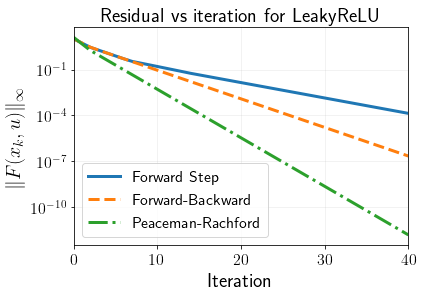

In [13]:
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams.update({'font.size': 16})
plt.grid(alpha=0.2)

fwdstepLR1 = np.load('FwdStepLRGamma-1.npy')
fwdbwdLR1 = np.load('FwdBwdLRGamma-1.npy')
PRLR1 = np.load('PRLRGamma-1.npy')

fwdstepLR1 = fwdstepLR1[0:41]
fwdbwdLR1 = fwdbwdLR1[0:41]
PRLR1 = PRLR1[0:41]

plt.plot(range(41),fwdstepLR1, label='Forward Step', linewidth = 3)
plt.plot(range(41),fwdbwdLR1, '--', label='Forward-Backward', linewidth = 3)
plt.plot(range(41),PRLR1, '-.', label='Peaceman-Rachford', linewidth = 3)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\|F(x_k,u)\|_{\infty}$', fontsize=20)
plt.title('Residual vs iteration for LeakyReLU', fontsize=20)
plt.xlim(0.0, 40.0)
#plt.title("Empirical robustness vs perturbation on MNIST")
plt.legend(ncol=1, loc='lower left')

plt.savefig("LR-1.pdf", bbox_inches='tight', dpi=300)

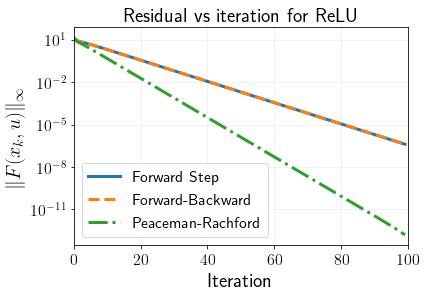

In [14]:
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams.update({'font.size': 16})
plt.grid(alpha=0.2)

fwdstepR09 = np.load('FwdStepReLGamma09.npy')
fwdbwdR09 = np.load('FwdBwdReLGamma09.npy')
PRR09 = np.load('PRReLGamma09.npy')

plt.plot(range(100),fwdstepR09, label='Forward Step', linewidth = 3)
plt.plot(range(100),fwdbwdR09, '--', label='Forward-Backward', linewidth = 3)
plt.plot(range(100),PRR09, '-.', label='Peaceman-Rachford', linewidth = 3)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\|F(x_k,u)\|_{\infty}$', fontsize=20)
plt.title('Residual vs iteration for ReLU', fontsize=20)
plt.xlim(0.0, 100.0)
#plt.title("Empirical robustness vs perturbation on MNIST")
plt.legend(ncol=1, loc='lower left')

plt.savefig("ReL09.pdf", bbox_inches='tight', dpi=300)

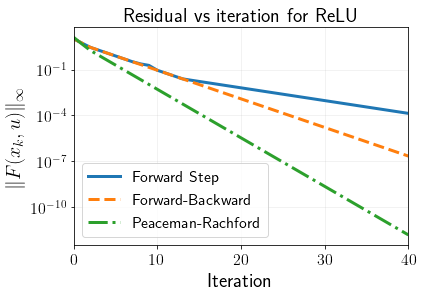

In [15]:
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams.update({'font.size': 16})
plt.grid(alpha=0.2)

fwdstepR1 = np.load('FwdStepReLGamma-1.npy')
fwdbwdR1 = np.load('FwdBwdReLGamma-1.npy')
PRR1 = np.load('PRReLGamma-1.npy')

fwdstepR1 = fwdstepR1[0:41]
fwdbwdR1 = fwdbwdR1[0:41]
PRR1 = PRR1[0:41]

plt.plot(range(41),fwdstepR1, label='Forward Step', linewidth = 3)
plt.plot(range(41),fwdbwdR1, '--', label='Forward-Backward', linewidth = 3)
plt.plot(range(41),PRR1, '-.', label='Peaceman-Rachford', linewidth = 3)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\|F(x_k,u)\|_{\infty}$', fontsize=20)
plt.title('Residual vs iteration for ReLU', fontsize=20)
plt.xlim(0.0, 40.0)
#plt.title("Empirical robustness vs perturbation on MNIST")
plt.legend(ncol=1, loc='lower left')

plt.savefig("ReL-1.pdf", bbox_inches='tight', dpi=300)